<a href="https://colab.research.google.com/github/Wizako-01/Cervical-Cell-Augmentation-GAN/blob/main/GAN_cervical_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import kagglehub



In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "wizako01"
os.environ['KAGGLE_KEY'] = "661ba16bb58f87c604c0708d61015e2b"

# Download the single-cell focused SIPaKMeD (~420MB)
!kaggle datasets download -d mohaliy2016/papsinglecell -p /content/ --unzip

print("Download complete! Folders:")
!ls /content/

Dataset URL: https://www.kaggle.com/datasets/mohaliy2016/papsinglecell
License(s): other
 96% 389M/403M [00:02<00:00, 120MB/s]
100% 403M/403M [00:02<00:00, 169MB/s]
Download complete! Folders:
sample_data  SingleCellPAP


In [5]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import torch.optim as optim  # This fixes the NameError

In [6]:
# --- 1. Define Hyperparameters ---
IMG_SIZE = 64
BATCH_SIZE = 64
CHANNELS_IMG = 3  # RGB images
Z_DIM = 100       # Latent vector size for Generator
NUM_CLASSES = 5   # Based on your dataset subfolders
TRAIN_DIR = '/content/SingleCellPAP/Training'

# --- 2. Define Transforms ---
# Normalization to (0.5, 0.5, 0.5) is critical for Tanh activation in GANs
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- 3. Initialize Dataset and Loader ---
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Successfully initialized DataLoader with {len(train_dataset)} images.")

Successfully initialized DataLoader with 3549 images.


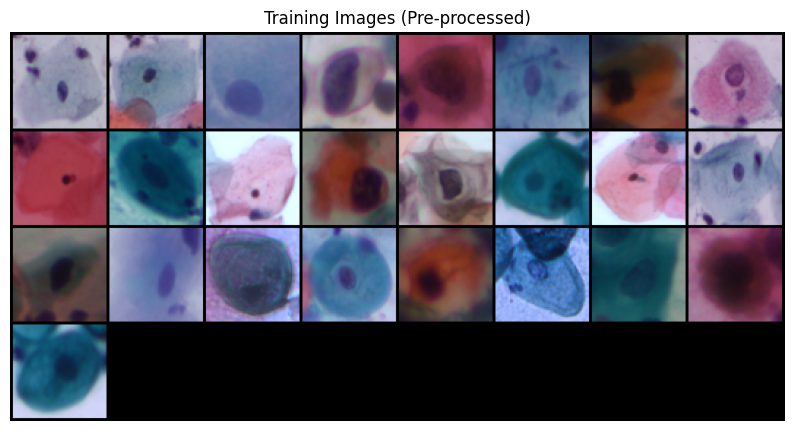

In [7]:
def plot_data_batch(loader):
    batch = next(iter(loader))
    images, labels = batch
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Training Images (Pre-processed)")
    plt.imshow(np.transpose(utils.make_grid(images[:25], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Optimized Loader for GAN Training
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Standard for DCGAN Tanh
])

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

plot_data_batch(train_loader)

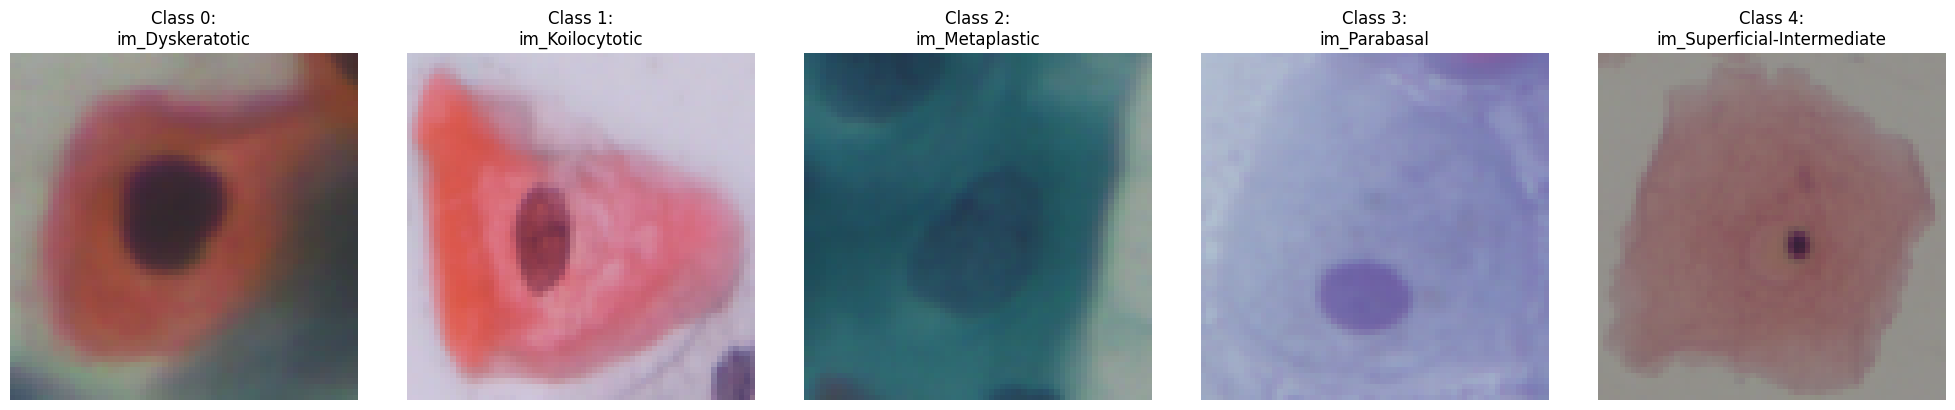

In [8]:
def visualize_classes(dataset):
    # Dictionary to store the first image found for each class
    found_images = {}

    # Iterate through the dataset to pick one sample per class
    for img, label in dataset:
        if label not in found_images:
            # Reverse normalization for visualization: (img * 0.5) + 0.5
            # This converts the [-1, 1] GAN range back to [0, 1] for plotting
            img_unnorm = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
            found_images[label] = img_unnorm

        if len(found_images) == len(dataset.classes):
            break

    # Plotting
    plt.figure(figsize=(20, 4))
    for i in range(len(dataset.classes)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(found_images[i])
        plt.title(f"Class {i}:\n{dataset.classes[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_classes(train_dataset)

In [9]:


# 1. Hyperparameters
IMG_SIZE = 64
CHANNELS_IMG = 3
NUM_CLASSES = 5
Z_DIM = 100
EMBED_SIZE = 100
LR = 2e-4
BATCH_SIZE = 64
EPOCHS = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Model Architectures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(NUM_CLASSES, EMBED_SIZE)
        self.gen = nn.Sequential(
            self._block(Z_DIM + EMBED_SIZE, 512, 4, 1, 0),
            self._block(512, 256, 4, 2, 1),
            self._block(256, 128, 4, 2, 1),
            self._block(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, CHANNELS_IMG, 4, 2, 1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(NUM_CLASSES, IMG_SIZE * IMG_SIZE)
        self.disc = nn.Sequential(
            nn.Conv2d(CHANNELS_IMG + 1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(64, 128, 4, 2, 1),
            self._block(128, 256, 4, 2, 1),
            self._block(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.label_emb(labels).view(labels.shape[0], 1, IMG_SIZE, IMG_SIZE)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)

# 3. Initialization
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

gen = Generator().to(device)
disc = Discriminator().to(device)
gen.apply(weights_init)
disc.apply(weights_init)

opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# 4. Training Function
def train_gan():
    print(f"Training on {device}...")
    for epoch in range(EPOCHS):
        for batch_idx, (real, labels) in enumerate(train_loader):
            real, labels = real.to(device), labels.to(device)
            batch_size = real.shape[0]

            # Train Discriminator
            disc.zero_grad()
            score_real = disc(real, labels).reshape(-1)
            loss_real = criterion(score_real, torch.ones_like(score_real))

            noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            score_fake = disc(fake.detach(), labels).reshape(-1)
            loss_fake = criterion(score_fake, torch.zeros_like(score_fake))

            loss_disc = (loss_real + loss_fake) / 2
            loss_disc.backward()
            opt_disc.step()

            # Train Generator
            gen.zero_grad()
            output = disc(fake, labels).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            loss_gen.backward()
            opt_gen.step()

        print(f"Epoch [{epoch}/{EPOCHS}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

# Execute
train_gan()

Training on cuda...
Epoch [0/50] Loss D: 0.0281, Loss G: 3.8430
Epoch [1/50] Loss D: 0.0185, Loss G: 4.2273
Epoch [2/50] Loss D: 0.1728, Loss G: 2.3737
Epoch [3/50] Loss D: 0.2836, Loss G: 1.3898
Epoch [4/50] Loss D: 0.4990, Loss G: 1.8822
Epoch [5/50] Loss D: 0.3187, Loss G: 2.7302
Epoch [6/50] Loss D: 0.2781, Loss G: 2.6828
Epoch [7/50] Loss D: 0.3048, Loss G: 2.6864
Epoch [8/50] Loss D: 0.2703, Loss G: 4.3619
Epoch [9/50] Loss D: 0.3327, Loss G: 1.5710
Epoch [10/50] Loss D: 0.5277, Loss G: 3.4695
Epoch [11/50] Loss D: 0.1889, Loss G: 3.0698
Epoch [12/50] Loss D: 0.6438, Loss G: 2.1628
Epoch [13/50] Loss D: 0.2061, Loss G: 3.5786
Epoch [14/50] Loss D: 0.3055, Loss G: 3.1162
Epoch [15/50] Loss D: 0.2510, Loss G: 3.0596
Epoch [16/50] Loss D: 0.2502, Loss G: 2.9059
Epoch [17/50] Loss D: 0.2250, Loss G: 3.7999
Epoch [18/50] Loss D: 0.2495, Loss G: 3.0382
Epoch [19/50] Loss D: 0.1457, Loss G: 2.9805
Epoch [20/50] Loss D: 0.2855, Loss G: 3.0287
Epoch [21/50] Loss D: 0.1833, Loss G: 3.4796


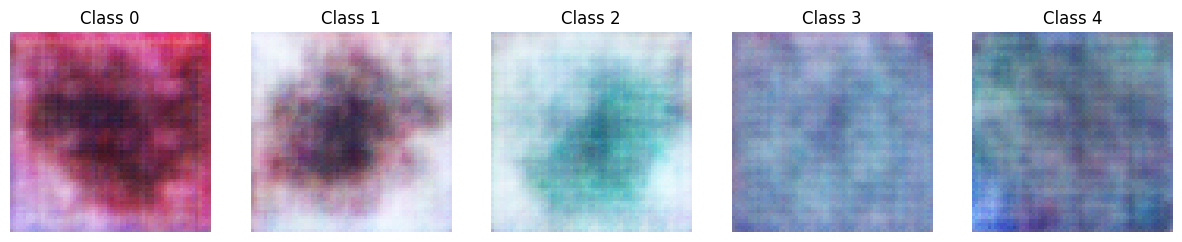

In [11]:
def visualize_results():
    gen.eval()
    with torch.no_grad():
        # Create noise and 5 labels (one for each class)
        noise = torch.randn(5, Z_DIM, 1, 1).to(device)
        labels = torch.arange(5).to(device)

        # Generate images and move back to CPU
        fakes = gen(noise, labels).detach().cpu()

        # Plotting
        plt.figure(figsize=(15, 5))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            # Rescale from [-1, 1] to [0, 1] for display
            img = fakes[i].permute(1, 2, 0) * 0.5 + 0.5
            plt.imshow(img)
            plt.title(f"Class {i}")
            plt.axis("off")
        plt.show()

visualize_results()

In [12]:
# Save the trained weights
torch.save(gen.state_dict(), "cDCGAN_generator.pth")
torch.save(disc.state_dict(), "cDCGAN_discriminator.pth")

print("Files saved: cDCGAN_generator.pth & cDCGAN_discriminator.pth")

Files saved: cDCGAN_generator.pth & cDCGAN_discriminator.pth


In [13]:
from collections import Counter

# Get current counts
counts = Counter(train_dataset.targets)
target_count = 1000  # Our goal for each class

print("Class Balancing Plan:")
generation_plan = {}
for class_idx, count in counts.items():
    if count < target_count:
        needed = target_count - count
        generation_plan[class_idx] = needed
        print(f"Class {class_idx} ({train_dataset.classes[class_idx]}): Need {needed} more.")
    else:
        print(f"Class {class_idx}: Already has {count} images (No generation needed).")

Class Balancing Plan:
Class 0 (im_Dyskeratotic): Need 287 more.
Class 1 (im_Koilocytotic): Need 275 more.
Class 2 (im_Metaplastic): Need 307 more.
Class 3 (im_Parabasal): Need 313 more.
Class 4 (im_Superficial-Intermediate): Need 269 more.


In [14]:
import os
from torchvision.utils import save_image

def balance_my_dataset(plan):
    gen.eval()
    base_dir = "Balanced_Dataset"

    for class_idx, num_to_generate in plan.items():
        class_name = train_dataset.classes[class_idx]
        save_path = f"{base_dir}/{class_name}"
        os.makedirs(save_path, exist_ok=True)

        print(f"Generating {num_to_generate} images for {class_name}...")

        with torch.no_grad():
            # Process in batches to avoid memory crashes
            batch_size = 32
            for i in range(0, num_to_generate, batch_size):
                current_batch = min(batch_size, num_to_generate - i)

                noise = torch.randn(current_batch, Z_DIM, 1, 1).to(device)
                labels = torch.full((current_batch,), class_idx, dtype=torch.long).to(device)

                fakes = gen(noise, labels)
                fakes = fakes * 0.5 + 0.5  # Denormalize to [0, 1]

                for j in range(current_batch):
                    img_name = f"synthetic_{i+j}.png"
                    save_image(fakes[j], f"{save_path}/{img_name}")

    print(f"✅ Success! All synthetic images saved in '{base_dir}' folder.")

# Run the balancing
balance_my_dataset(generation_plan)

Generating 287 images for im_Dyskeratotic...
Generating 275 images for im_Koilocytotic...
Generating 307 images for im_Metaplastic...
Generating 313 images for im_Parabasal...
Generating 269 images for im_Superficial-Intermediate...
✅ Success! All synthetic images saved in 'Balanced_Dataset' folder.


In [15]:
!zip -r balanced_cells.zip Balanced_Dataset/
print("Zip file ready for download!")

  adding: Balanced_Dataset/ (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/ (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_39.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_49.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_259.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_188.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_93.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_105.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_235.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_156.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_148.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_46.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_268.png (stored 0%)
  adding: Balanced_Dataset/im_Koilocytotic/synthetic_141.png (stored 0%)
  adding: Balanced_Dataset/im_Ko

In [16]:

# Save the model weights
torch.save(gen.state_dict(), "generator.pth")

# Generate a final showcase grid for the README
gen.eval()
with torch.no_grad():
    # 5 images for each of the 5 classes
    noise = torch.randn(25, Z_DIM, 1, 1).to(device)
    labels = torch.tensor([0, 1, 2, 3, 4] * 5).to(device)
    samples = gen(noise, labels)
    vutils.save_image(samples, "results_grid.png", nrow=5, normalize=True)

print("Files prepared: generator.pth and results_grid.png")

Files prepared: generator.pth and results_grid.png
